In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [452]:
# Read all four CSV files
df_byState_bytotal = pd.read_csv("merged_fips_median_byState_bytotal_data.csv")
df_median = pd.read_csv("merged_fips_median_data.csv")
df_moving_avg = pd.read_csv("merged_fips_moving_average_data.csv")
df_ffill_bfill_median = pd.read_csv("ffill_bfill_median_data.csv")
# Optional: display their shapes to verify successful loading
print("byState_bytotal:", df_byState_bytotal.shape)
print("median:", df_median.shape)
print("moving_average:", df_moving_avg.shape)
print("ffill_bfill_median:", df_ffill_bfill_median.shape)

byState_bytotal: (3994, 76)
median: (3994, 76)
moving_average: (3994, 76)
ffill_bfill_median: (3994, 76)


In [453]:
df_byState_bytotal.head()

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,...,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,smoothed_wcli_lagged,smoothed_wpublic_transit_1d_lagged,smoothed_wcovid_vaccinated_lagged,smoothed_wvaccine_likely_friends_lagged
0,1/7/2021,1000,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,29.288429,30.487852,...,False,False,False,False,False,False,3.244379,1.464798,2.638200,28.469582
1,1/7/2021,2000,31.031930,23.187988,5.247612,54.332976,31.829591,52.948188,8.843686,31.242179,...,False,False,False,False,False,False,0.421245,5.247612,2.638200,29.240819
2,1/7/2021,4000,33.894471,15.813525,1.670934,70.449040,30.601786,52.224064,30.302464,26.614385,...,False,False,False,False,False,False,3.244379,1.464798,15.910167,38.028305
3,1/7/2021,4013,30.674532,16.170044,3.106310,68.928567,32.197435,50.983665,22.710935,24.467235,...,False,False,False,False,False,False,0.421245,5.247612,4.715310,34.448458
4,1/7/2021,4019,30.489939,16.193151,2.943076,69.579201,36.636282,52.706816,21.912277,24.371077,...,False,False,False,False,False,False,1.401254,1.670934,4.005679,36.117471


In [454]:
df_byState_bytotal.isnull().sum()

time_value                                 0
geo_value                                  0
smoothed_wspent_time_1d                    0
smoothed_wtested_14d                       0
smoothed_wpublic_transit_1d                0
                                          ..
State_Wisconsin                            0
smoothed_wcli_lagged                       0
smoothed_wpublic_transit_1d_lagged         0
smoothed_wcovid_vaccinated_lagged          0
smoothed_wvaccine_likely_friends_lagged    0
Length: 76, dtype: int64

Drop two colunms below, which highly correlated with smoothed_wvaccine_likely_who, smoothed_wothers_masked. The colunms having more missing values are selected 

In [455]:
df_byState_bytotal.drop(columns=['smoothed_wvaccine_likely_govt_health', 'smoothed_wwearing_mask'], inplace=True)

In [456]:
df_byState_bytotal['time_value'] = pd.to_datetime(df_byState_bytotal['time_value'])
df_byState_bytotal['month'] = df_byState_bytotal['time_value'].dt.month
df_byState_bytotal['week'] = df_byState_bytotal['time_value'].dt.isocalendar().week
df_byState_bytotal['dayofweek'] = df_byState_bytotal['time_value'].dt.dayofweek

In [457]:


# Drop unnecessary columns
drop_cols = ['time_value', 'geo_value', 'County Name','smoothed_wtested_positive_14d']
X = df_byState_bytotal.drop(columns=drop_cols)
y = df_byState_bytotal['smoothed_wtested_positive_14d']

In [458]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True  # if it's time series, keep shuffle=False
)


In [459]:
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 8],
    'max_features': [0.3, 'sqrt']
}


grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

# Optional: use best estimator to predict on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Test RMSE: {rmse_best:.2f}")
print(f"Best Model - Test R²: {r2_best:.3f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best CV R² Score: 0.8209964939320697
Best Model - Test RMSE: 3.16
Best Model - Test R²: 0.831


In [460]:
cv_results = pd.DataFrame(grid_search.cv_results_)

top_r2 = cv_results.sort_values("mean_test_score", ascending=False).head()

print(top_r2[[
    'mean_test_score', 'mean_train_score', 'params', 'rank_test_score'
]])


    mean_test_score  mean_train_score  \
8          0.820996          0.931474   
9          0.815969          0.924463   
0          0.795642          0.894031   
12         0.794675          0.898566   
1          0.794063          0.889519   

                                               params  rank_test_score  
8   {'max_depth': 15, 'max_features': 0.3, 'min_sa...                1  
9   {'max_depth': 15, 'max_features': 0.3, 'min_sa...                2  
0   {'max_depth': 10, 'max_features': 0.3, 'min_sa...                3  
12  {'max_depth': 15, 'max_features': 'sqrt', 'min...                4  
1   {'max_depth': 10, 'max_features': 0.3, 'min_sa...                5  


Best Model - Test RMSE: 3.16
Best Model - Test R²: 0.831


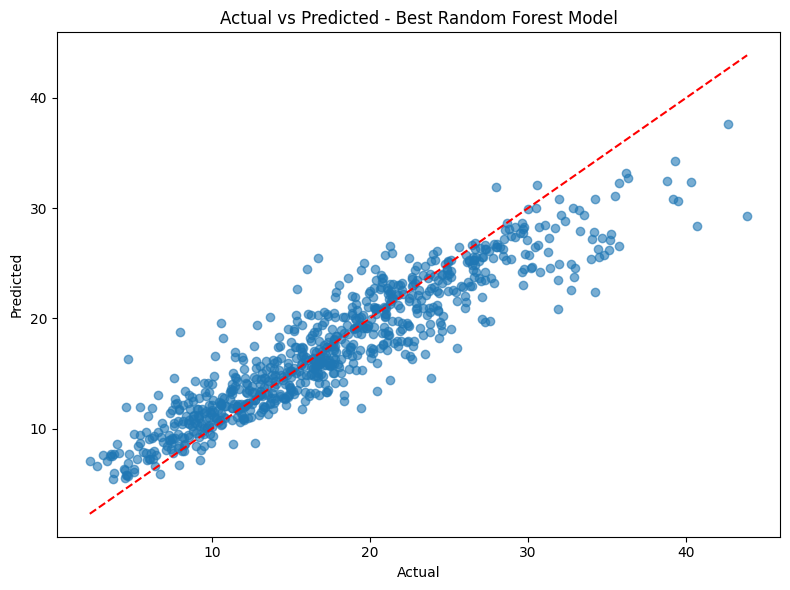

In [461]:
print(f"Best Model - Test RMSE: {rmse_best:.2f}")
print(f"Best Model - Test R²: {r2_best:.3f}")

# Optional: Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Best Random Forest Model")
plt.tight_layout()
plt.show()

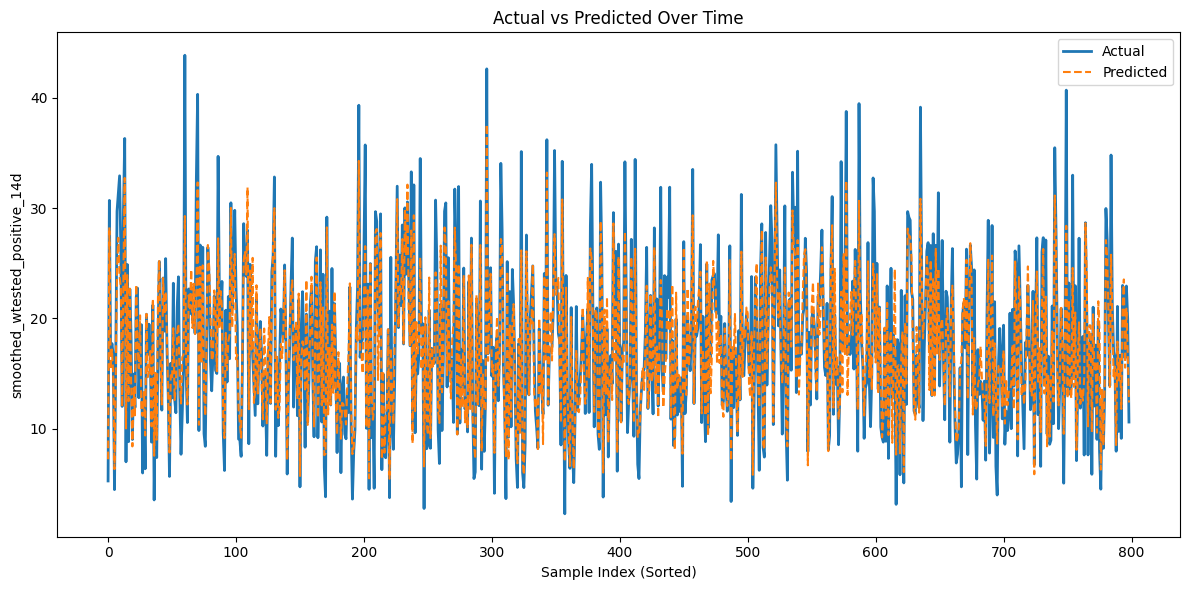

In [462]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=2)
plt.plot(range(len(y_pred_best)), y_pred_best, label='Predicted', linestyle='--')
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("smoothed_wtested_positive_14d")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.tight_layout()
plt.show()

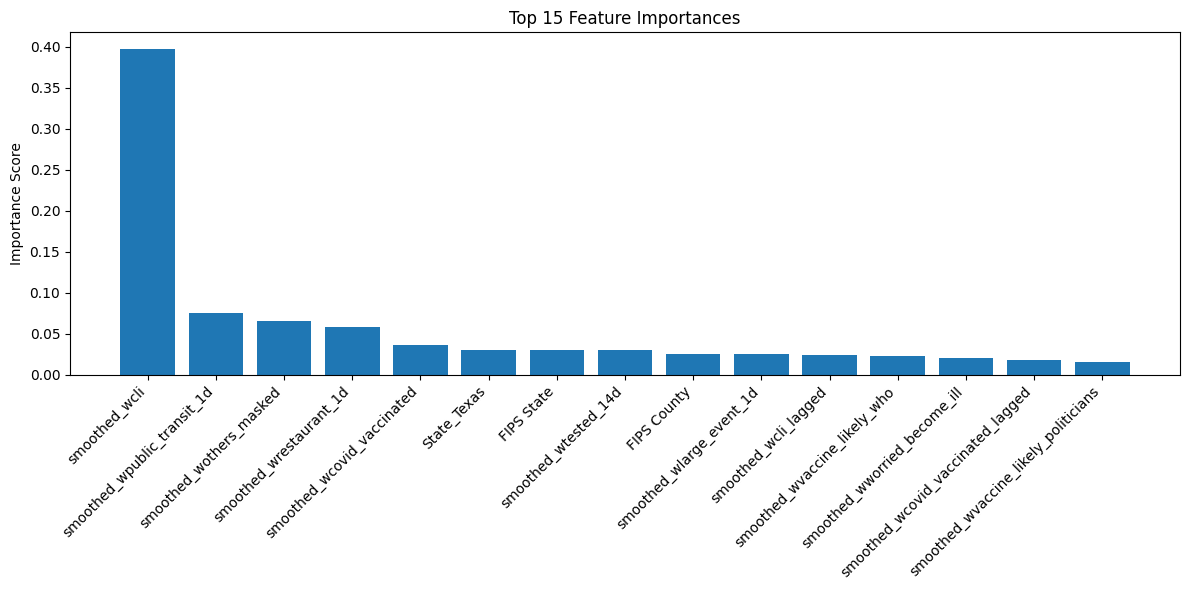

In [463]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=45, ha="right")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


Neighborhood and lagged version 

In [511]:
df_byState_bytotal_lagged = df_byState_bytotal.copy() 

In [512]:
df_byState_bytotal_lagged = df_byState_bytotal_lagged.sort_values(['FIPS County', 'time_value'])


In [513]:
df_byState_bytotal_lagged['time_value'] = pd.to_datetime(df_byState_bytotal_lagged['time_value'])
df_byState_bytotal_lagged = df_byState_bytotal_lagged.sort_values(['FIPS County', 'time_value'])



In [514]:

df_byState_bytotal_lagged['lag_1'] = df_byState_bytotal_lagged.groupby('FIPS County')['smoothed_wtested_positive_14d'].shift(1)
df_byState_bytotal_lagged['lag_2'] = df_byState_bytotal_lagged.groupby('FIPS County')['smoothed_wtested_positive_14d'].shift(2)

In [515]:
df_byState_bytotal_lagged['time_value'] = pd.to_datetime(df_byState_bytotal_lagged['time_value'])
df_byState_bytotal_lagged['month'] = df_byState_bytotal_lagged['time_value'].dt.month
df_byState_bytotal_lagged['week'] = df_byState_bytotal_lagged['time_value'].dt.isocalendar().week
df_byState_bytotal_lagged['dayofweek'] = df_byState_bytotal_lagged['time_value'].dt.dayofweek

In [516]:
def compute_state_neighbor_lag(df, lag_col):
    neighbor_means = []

    for idx, row in df.iterrows():
        state = row['FIPS State']
        county = row['FIPS County']
        date = row['time_value']

        # Mask: same date, same state, but different county
        mask = (
            (df['time_value'] == date) &
            (df['FIPS State'] == state) &
            (df['FIPS County'] != county)
        )

        mean_val = df.loc[mask, lag_col].mean()
        neighbor_means.append(mean_val)

    return neighbor_means


In [517]:
df_byState_bytotal_lagged['neighbor_lag_1'] = compute_state_neighbor_lag(df_byState_bytotal_lagged, 'lag_1')
df_byState_bytotal_lagged['neighbor_lag_2'] = compute_state_neighbor_lag(df_byState_bytotal_lagged, 'lag_2')

In [518]:
# List of columns to fill
lag_cols = ['neighbor_lag_1', 'neighbor_lag_2', 'lag_1', 'lag_2']

# Loop through each column and apply group-based fill
for col in lag_cols:
    # Compute the national average per day for the current column
    daily_avg = df_byState_bytotal_lagged.groupby('time_value')[col].transform('mean')

    # Replace NaNs in that column with the national average for the same day
    df_byState_bytotal_lagged[col] = df_byState_bytotal_lagged[col].fillna(daily_avg)

In [519]:
df_byState_bytotal_lagged = df_byState_bytotal.copy() 

In [520]:
df_byState_bytotal_lagged.isnull().sum()

time_value                     0
geo_value                      0
smoothed_wspent_time_1d        0
smoothed_wtested_14d           0
smoothed_wpublic_transit_1d    0
                              ..
dayofweek                      0
lag_1                          0
lag_2                          0
neighbor_lag_1                 0
neighbor_lag_2                 0
Length: 81, dtype: int64

In [521]:
df_byState_bytotal_lagged.head()

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,...,smoothed_wpublic_transit_1d_lagged,smoothed_wcovid_vaccinated_lagged,smoothed_wvaccine_likely_friends_lagged,month,week,dayofweek,lag_1,lag_2,neighbor_lag_1,neighbor_lag_2
0,2021-01-07,1000,34.412959,12.541558,1.464798,65.771681,52.854667,29.288429,30.487852,57.334785,...,1.464798,2.638200,28.469582,1,1,3,19.612384,20.397145,19.367735,21.212834
1,2021-01-07,2000,31.031930,23.187988,5.247612,54.332976,52.948188,8.843686,31.242179,65.756589,...,5.247612,2.638200,29.240819,1,1,3,29.288429,20.397145,19.367735,21.212834
2,2021-01-07,4000,33.894471,15.813525,1.670934,70.449040,52.224064,30.302464,26.614385,64.266832,...,1.464798,15.910167,38.028305,1,1,3,8.843686,29.288429,19.367735,21.212834
5,2021-01-07,5000,32.736613,11.899913,1.998309,65.860855,50.956848,26.660268,28.378487,64.068087,...,3.106310,6.249659,26.838055,1,1,3,30.302464,8.843686,19.367735,21.212834
6,2021-01-07,6000,29.420633,10.226604,1.892436,68.810293,53.276655,19.416862,24.792770,78.550036,...,2.943076,6.519826,30.801686,1,1,3,26.660268,30.302464,22.311606,21.212834


In [522]:
# Drop unnecessary columns
drop_cols = ['time_value', 'geo_value', 'County Name','smoothed_wtested_positive_14d']
X = df_byState_bytotal_lagged.drop(columns=drop_cols)
y = df_byState_bytotal_lagged['smoothed_wtested_positive_14d']

In [523]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True  # if it's time series, keep shuffle=False
)


In [524]:
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 8],
    'max_features': [0.3, 'sqrt']
}


grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

# Optional: use best estimator to predict on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Test RMSE: {rmse_best:.2f}")
print(f"Best Model - Test R²: {r2_best:.3f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best CV R² Score: 0.8441743955445877
Best Model - Test RMSE: 2.69
Best Model - Test R²: 0.867


In [525]:
cv_results = pd.DataFrame(grid_search.cv_results_)

top_r2 = cv_results.sort_values("mean_test_score", ascending=False).head()

print(top_r2[[
    'mean_test_score', 'mean_train_score', 'params', 'rank_test_score'
]])

    mean_test_score  mean_train_score  \
8          0.844174          0.943358   
9          0.840113          0.937006   
0          0.828004          0.918564   
1          0.825582          0.914177   
12         0.817638          0.915246   

                                               params  rank_test_score  
8   {'max_depth': 15, 'max_features': 0.3, 'min_sa...                1  
9   {'max_depth': 15, 'max_features': 0.3, 'min_sa...                2  
0   {'max_depth': 10, 'max_features': 0.3, 'min_sa...                3  
1   {'max_depth': 10, 'max_features': 0.3, 'min_sa...                4  
12  {'max_depth': 15, 'max_features': 'sqrt', 'min...                5  


Best Model - Test RMSE: 2.69
Best Model - Test R²: 0.867


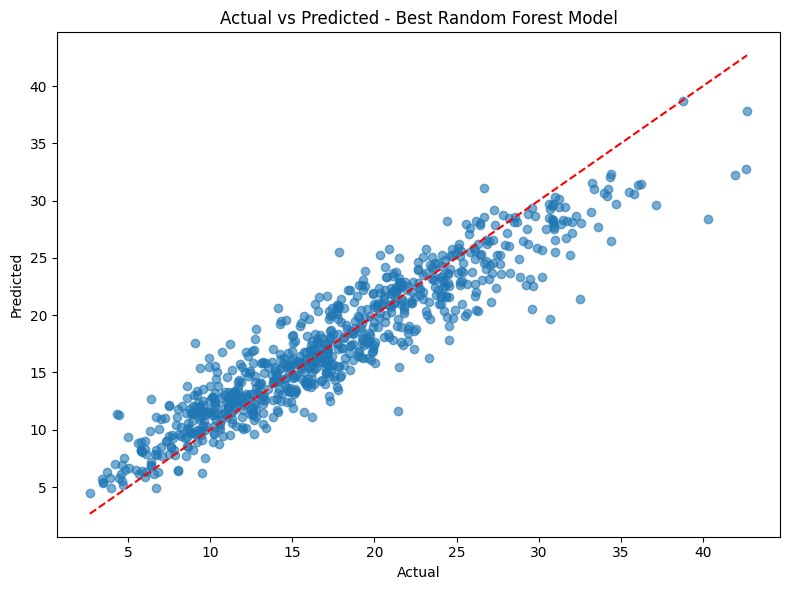

In [526]:
print(f"Best Model - Test RMSE: {rmse_best:.2f}")
print(f"Best Model - Test R²: {r2_best:.3f}")

# Optional: Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Best Random Forest Model")
plt.tight_layout()
plt.show()

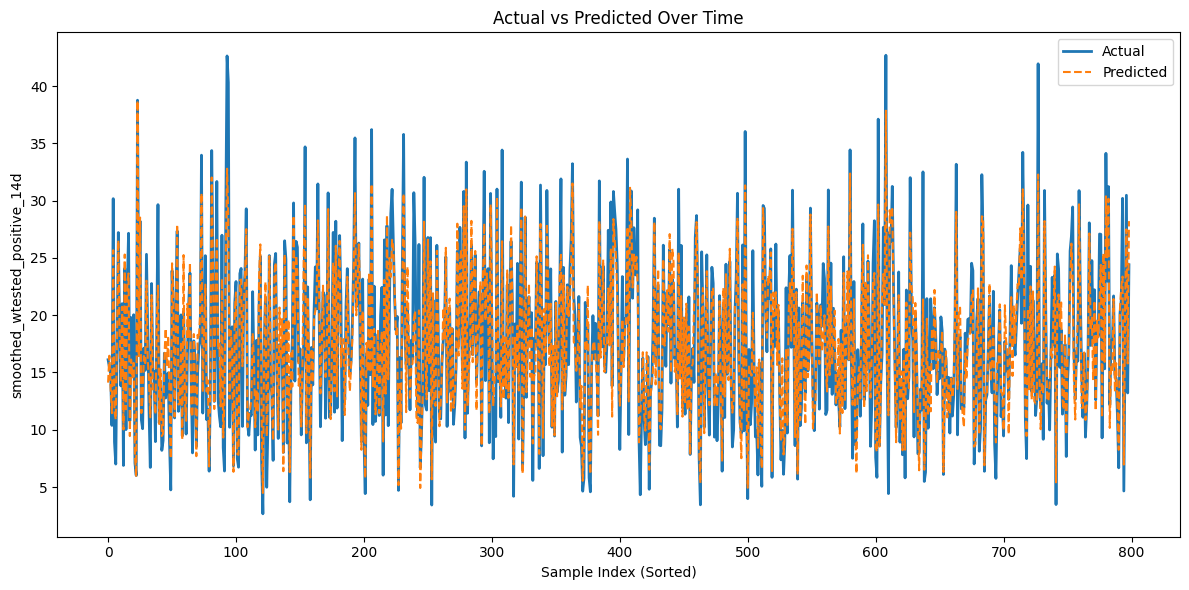

In [527]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=2)
plt.plot(range(len(y_pred_best)), y_pred_best, label='Predicted', linestyle='--')
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("smoothed_wtested_positive_14d")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.tight_layout()
plt.show()

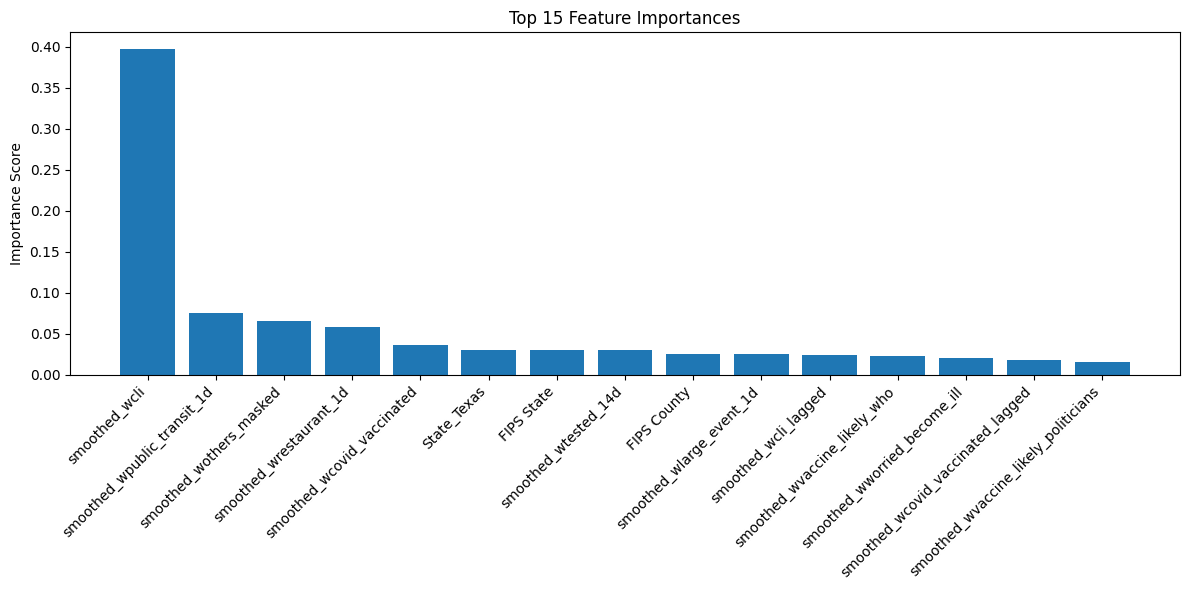

In [528]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=45, ha="right")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()